In [1]:
# common
import re
import xml.etree.ElementTree as ET
textpath = "data/nlp.txt"


## 50. 文区切り
(. or ; or : or ? or !) → 空白文字 → 英大文字というパターンを文の区切りと見なし，入力された文書を1行1文の形式で出力せよ．

In [ ]:
with open(textpath) as text, open("out/50.txt", "w") as f:
    f.write(re.sub(r"(?<=[.;:?!])\s(?=[A-Z])", "\n", text.read()))

## 51. 単語の切り出し
空白を単語の区切りとみなし，50の出力を入力として受け取り，1行1単語の形式で出力せよ．ただし，文の終端では空行を出力せよ．

In [ ]:
with open("out/50.txt") as text, open("out/51.txt", "w") as f:
    space2nl = re.sub("\s", "\n", text.read())
    new_text = re.sub("\.\n", ".\n\n", space2nl)
    f.write(new_text)

## 52. ステミング
51の出力を入力として受け取り，Porterのステミングアルゴリズムを適用し，単語と語幹をタブ区切り形式で出力せよ． Pythonでは，Porterのステミングアルゴリズムの実装としてstemmingモジュールを利用するとよい．

In [ ]:
from nltk.stem.porter import PorterStemmer as PS
ps = PS()

with open("out/51.txt") as words, open("out/52.txt", "w") as f:
    for word in words:
        f.write(word.strip() + "\t" + ps.stem(word.strip()) + "\n")

## 53. Tokenization
Stanford Core NLPを用い，入力テキストの解析結果をXML形式で得よ．また，このXMLファイルを読み込み，入力テキストを1行1単語の形式で出力せよ．

### memo
`java -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLP -file nlp.txt`

- root
    0. docID
    1. sentences
        - sentence
            - tokens
                - token 
                    0. word
                    1. lemma
                    2. CharacterOffsetBegin
                    3. CharacterOffsetEnd
                    4. POS
                    5. NER
                    6. Speaker    
            - dependencies
                - dep
                    0. governor
                    1. dependent
    2. coreferences
        - coreference
            - mention
                0. sentence
                1. start
                2. end
                3. head
                4. text
        

In [ ]:
tree = ET.parse("data/nlp.txt.xml")
root = tree.getroot()

for token in root.iter('token'):
    1
    #print(token[0].text)

## 54. 品詞タグ付け
Stanford Core NLPの解析結果XMLを読み込み，単語，レンマ，品詞をタブ区切り形式で出力せよ．

In [ ]:
tree = ET.parse("data/nlp.txt.xml")
root = tree.getroot()

for token in root.iter('token'):
    line = '\t'.join(map(lambda i: token[i].text, [0,1,4]))
    #print(line)

## 55. 固有表現抽出
入力文中の人名をすべて抜き出せ．

In [ ]:
tree = ET.parse("data/nlp.txt.xml")
root = tree.getroot()

for token in root.iter('token'):
    if token[5].text == "PERSON":
        print(token[0].text)

## 56. 共参照解析
Stanford Core NLPの共参照解析の結果に基づき，文中の参照表現（mention）を代表参照表現（representative mention）に置換せよ．ただし，置換するときは，「代表参照表現（参照表現）」のように，元の参照表現が分かるように配慮せよ．

### memo
- mention
                0. sentence 何文目
                1. start (token)
                2. end (token)
                3. head
                4. text

sentence, token ID のcharacteroffsetbegin / end の範囲を置換する

In [ ]:
tree = ET.parse("data/nlp.txt.xml")
root = tree.getroot()

sub_list = []
for coreference in root[0][2]:
    for mention in coreference:
        if mention.attrib: # representative
            rep =  mention[4].text
        else:
            _sid, _ts, _te, _, ment = [attr.text for attr in mention]
            sentence_id, token_start, token_end = int(_sid)-1, int(_ts)-1, int(_te)-2
            start = int(root[0][1][sentence_id][0][token_start][2].text)
            end = int(root[0][1][sentence_id][0][token_end][3].text)
            if rep != ment:
                sub_list.append((start, end, rep, ment)) 

sub_list.sort(key= lambda t: -t[1])

with open(textpath) as text, open("out/56.txt" , 'w') as out:
    string = text.read()
    for start, end, rep, ment in sub_list:
        repl = rep + '(' + ment + ')'
        string = string[:start] + re.sub(ment, repl, string[start:],1)
        
    out.write(string)

## 57. 係り受け解析
Stanford Core NLPの係り受け解析の結果（collapsed-dependencies）を有向グラフとして可視化せよ．可視化には，係り受け木をDOT言語に変換し，Graphvizを用いるとよい．また，Pythonから有向グラフを直接的に可視化するには，pydotを使うとよい．

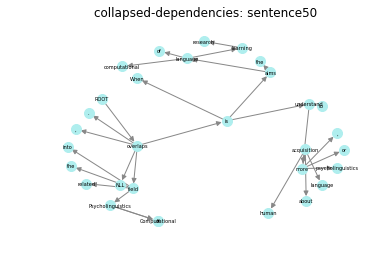

In [21]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

tree = ET.parse("data/nlp.txt.xml")
root = tree.getroot()

sentences = root.find('*/sentences')
whole = len(sentences)

with PdfPages("img/57.pdf") as pdf:
    for sentence in sentences:
        sid = sentence.get('id')

        # generate labels
        node_label = {'0': 'ROOT'}
        for token in sentence.find('tokens'):
            node_label[token.get('id')] = token[0].text

        # generate graph
        G = nx.DiGraph()
        G.add_nodes_from(node_label.keys())
        for dep in sentence.find('dependencies[@type="collapsed-dependencies"]'):
            G.add_edge(*tuple(elm.get('idx') for elm in dep))

        # draw graph
        plt.clf()
        plt.title("collapsed-dependencies: sentence"+sid)
        settings = {
            'pos': nx.spring_layout(G, k=1.5, pos=nx.spectral_layout(G)),
            'node_size': 100,
            'node_color': '#afeeee',
            'edge_color': '#888888',
            'labels': node_label,
            'with_label': True,
            'font_size': 5,
        }
        nx.draw(G, **settings)
        
        # save figure to pdf
        pdf.savefig()
        print(sid,"/",whole,"Done", end="\r")

plt.show()

## 58. タプルの抽出
Stanford Core NLPの係り受け解析の結果（collapsed-dependencies）に基づき，「主語 述語 目的語」の組をタブ区切り形式で出力せよ．ただし，主語，述語，目的語の定義は以下を参考にせよ．

- 述語: nsubj関係とdobj関係の子（dependant）を持つ単語
- 主語: 述語からnsubj関係にある子（dependent）
- 目的語: 述語からdobj関係にある子（dependent）

### memo
動詞ID→主語ID, 目的語IDの辞書をつくってkeyの共通部分を抽出

In [20]:
from collections import defaultdict

def get_word_from_id(sentence, str_id):
    return sentence[0][int(str_id)-1][0].text
    

tree = ET.parse("data/nlp.txt.xml")
root = tree.getroot()

sentences = root.find('*/sentences')
for sentence in sentences:
    v2s, v2o = {}, {}
    for dep in sentence.find('dependencies[@type="collapsed-dependencies"]'):
        g, d = [elm.get('idx') for elm in dep]
        if dep.get('type') == "nsubj":
            v2s[g] = d
        elif dep.get('type') == "dobj":
            v2o[g] = d
            
    verbs = list(set(v2s.keys()) & set(v2o.keys()))
    if verbs:
        for verb in verbs:
            svo = [get_word_from_id(sentence, str_id) for str_id in [v2s[verb], verb, v2o[verb]]]
            print('\t'.join(svo))

understanding	involve	generation
Turing	published	article
experiment	involved	translation
ELIZA	provided	interaction
patient	exceeded	base
ELIZA	provide	response
which	structured	information
that	underlies	approach
underpinnings	discouraged	sort
Some	produced	systems
which	make	decisions
that	contains	errors
implementations	involved	coding
algorithms	take	set
Some	produced	systems
which	make	decisions
they	express	certainty
models	have	advantage
Systems	have	advantages
procedures	make	use
that	make	decisions


## 59. S式の解析
Stanford Core NLPの句構造解析の結果（S式）を読み込み，文中のすべての名詞句（NP）を表示せよ．入れ子になっている名詞句もすべて表示すること．